<a href="https://colab.research.google.com/github/Victorlouisdg/Jax-Cloth-Tutorial/blob/main/Jax%20Cloth%20Tutorial%20-%20Part%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jax Cloth Tutorial 👗 - Part 2



## Code we need from part 1

In [1]:
import jax.numpy as jnp

def deformation_gradient(positions, positions_uv):
    u0, u1, u2 = positions_uv
    Dm = jnp.column_stack([u1 - u0, u2 - u0])
    Dm_inv = jnp.linalg.inv(Dm)

    x0, x1, x2 = positions
    Ds = jnp.column_stack([x1 - x0, x2 - x0])

    F = Ds @ Dm_inv
    return F

In [2]:
import plotly.graph_objs as go
import plotly.io as pio

pio.templates.default = "plotly_white" # also nice: "simple_white"
pio.renderers.default = "colab"
# pio.renderers.default = "svg" # static plots for Github
# pio.renderers.default = "notebook_connected" # interactive plots for NBViewer

def get_vertices_go(positions, color='deeppink'):
    x, y, z = positions.T
    vertices_go = go.Scatter3d(x=x, y=y, z=z,
                               mode='markers+text',
                               marker=dict(size=5, color=color),
                               text=[str(i) for i in range(len(positions))])
    return vertices_go

def get_mesh_go(positions, triangles, color='deepskyblue', opacity=1.0):
    x, y, z = positions.T
    i, j, k = triangles.T
    mesh_go = go.Mesh3d(x=x, y=y, z=z,
                        i=i, j=j, k=k,
                        color=color,
                        opacity=opacity,
                        hoverinfo='skip')
    return mesh_go

def get_cones_go(positions, directions,):
    x, y, z = positions.T
    u, v, w = directions.T
    cones_go = go.Cone(x=x, y=y, z=z,
                       u=u, v=v, w=w,
                       sizemode='scaled',
                       sizeref=0.2)
    return cones_go

def make_fig(data, 
             xrange=[-0.6, 1.6], 
             yrange=[-1.1, 1.1], 
             zrange=[-1.6, 0.6], 
             eye=dict(x=-1.0, y=-1.0, z=1.0),
             center=None,
             up=None):
    fig = go.Figure(data=data)
    fig.update_layout(scene = dict(
        xaxis=dict(range=xrange, autorange=False),
        yaxis=dict(range=yrange, autorange=False),
        zaxis=dict(range=zrange, autorange=False),
        aspectmode='cube',
        camera = dict(eye=eye, center=center, up=up)
    ))

    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0)) # tight layout
    return fig

def frame_data(positions, triangles):
    return [
       get_vertices_go(positions),
       get_mesh_go(positions, triangles)
    ]

def animate_cloth(history, triangles, dt, fps=30):

    fig = make_fig(frame_data(positions, triangles))

    fps_simulation = 1 / dt
    skip = jnp.floor(fps_simulation / fps).astype(jnp.int32)
    fps_adjusted = fps_simulation / skip
    print(f'fps was adjusted to: {fps_adjusted:.2f}')

    fig.update_layout(updatemenus=[dict(type="buttons",
                          buttons=[dict(label="Play",
                                        method="animate",
                                        args=[None, dict(frame=dict(redraw=True,fromcurrent=True, mode='immediate'))]
                                        )])])

    fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 1000.0 / fps_adjusted

    indices = jnp.arange(0, len(history), skip)
    frames = [go.Frame(data=frame_data(history[i], triangles)) for i in indices]

    fig.update(frames=frames)
    fig.show()

In [3]:
def area(triangle_vertices):
    v0, v1, v2 = triangle_vertices
    return jnp.linalg.norm(jnp.cross(v1 - v0, v2 - v0)) / 2.0

def energy(positions, positions_uv, ku, kv):
    a = area(positions_uv)

    F = deformation_gradient(positions, positions_uv)
    wu, wv = jnp.hsplit(F, 2)
    Cu = jnp.linalg.norm(wu) - 1
    Cv = jnp.linalg.norm(wv) - 1

    Eu = 0.5 * a * ku * (Cu ** 2)
    Ev = 0.5 * a * kv * (Cv ** 2)
    return Eu + Ev

In [4]:
!pip install meshzoo

In [5]:
import meshzoo

positions_uv, triangles = meshzoo.rectangle_tri(
    (0.0, 0.0),
    (1.0, 1.0),
    n=4,
    variant="zigzag",
)

positions_uv = jnp.array(positions_uv)

amount_of_vertices = positions_uv.shape[0]
amount_of_triangles = triangles.shape[0]

positions_z = jnp.zeros(amount_of_vertices)
positions = jnp.column_stack([positions_uv, positions_z])

In [6]:
data = [get_vertices_go(positions),
        get_mesh_go(positions, triangles)]

make_fig(data,
        xrange=[-0.1, 1.1], 
        yrange=[-0.1, 1.1], 
        zrange=[-0.6, 0.6]).show()

In [7]:
from functools import partial
from jax import vmap

def mesh_energy(positions_flat, positions_uv, triangles, energy_fn):
    positions = positions_flat.reshape(-1, 3)
    energies = vmap(energy_fn)(positions[triangles],
                               positions_uv[triangles])
    total_energy = jnp.sum(energies)
    return -total_energy

energy_fn = partial(energy, ku=10000.0, kv=10000.0)
mesh_energy(positions, positions_uv, triangles, energy_fn)

DeviceArray(-0., dtype=float32)

In [8]:
from jax import grad

mesh_energy_fn = partial(mesh_energy, 
                         positions_uv=positions_uv,
                         triangles=triangles,
                         energy_fn=energy_fn)

forces_fn = grad(mesh_energy_fn)

In [9]:
from jax.lax import scan

def simulate(step_fn, initial_state, amount_of_steps):
    carry, outputs = scan(step_fn, 
                          initial_state, 
                          xs=None, 
                          length=amount_of_steps)
    return outputs

## New step function

In [10]:
from jax import jacobian, hessian

force_derivatives_fn = jacobian(forces_fn)

# or equivalently:
energy_hessian_fn = hessian(mesh_energy_fn)

In [11]:
from jax.ops import index

system_size = 3 * amount_of_vertices

m = 1.0 / amount_of_vertices
masses = jnp.full(system_size, m)
M = jnp.diag(masses)
S = jnp.identity(system_size)

pinned = jnp.array([0, 4])

for i in pinned:
    S = S.at[index[3*i:3*i+3, 3*i:3*i+3]].set(0.0)

z = jnp.zeros(system_size)

dt = 0.01

In [12]:
g = [0.0, 0.0, -9.81] * amount_of_vertices
gravity = masses * jnp.array(g)

gravity.shape

(75,)

In [13]:
import jax.scipy.sparse

def build_system(positions, velocities, dt):
    h = dt
    x0 = positions.flatten()
    v0 = velocities.flatten()
    f0 = forces_fn(x0)
    f0 = f0 + gravity
    dfdx = force_derivatives_fn(x0)

    # Equation (16) in Baraff-Witkin.
    A = M - (h * h) * dfdx
    b = h * (f0 + h * (dfdx @ v0))

    return A, b

def filter_system(A, b, S, z):
    # Prefiltering the system (see also: Dynamic Deformables section 10.1.1)
    I = jnp.identity(system_size)
    LHS = (S @ A @ S) + I - S
    c = b - A @ z
    rhs = S @ c
    return LHS, rhs


def PPCG(A, b, S, z):
    LHS, rhs = filter_system(A, b, S, z)
    LHS_fn = lambda x : LHS @ x

    y = jax.scipy.sparse.linalg.cg(LHS_fn, rhs)[0]
    x = y + z
    return x


def step(carry, input, forces_fn, masses, S, z, dt):
    positions, velocities = carry

    A, b = build_system(positions, velocities, dt)

    x = PPCG(A, b, S, z)

    delta_v = x.reshape(-1, 3)

    velocities_new = velocities + delta_v
    positions_new  = positions + velocities_new * dt

    carry = (positions_new, velocities_new)
    output = positions_new
    return (carry, output)

step_fn = partial(step,
                  forces_fn=forces_fn,
                  masses=masses,
                  S=S,
                  z=z,
                  dt=dt)

In [14]:
velocities = jnp.zeros_like(positions)
initial_state = positions, velocities

history = simulate(step_fn, initial_state, 1000)

In [15]:
animate_cloth(history, triangles, dt)

fps was adjusted to: 33.33


Text(0.5, 1.05, 'Force Jacobian Sparisty Pattern')

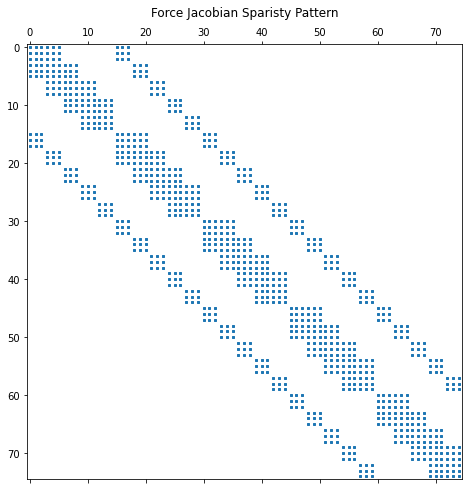

In [16]:
import matplotlib.pyplot as plt

dfdx = force_derivatives_fn(history[-1].flatten())
plt.figure(figsize=(8,8))
plt.spy(dfdx, markersize=2.8);

plt.title('Force Jacobian Sparisty Pattern')